In [17]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
import csv

In [3]:
data_df = pd.read_csv('../predicting-satisfaction-using-graphs/csv/dataset/avg_satisfaction_raw_0-999.csv', encoding='ISO-8859-1')

In [4]:
list_satisfaction = list(data_df['satisfy_composite'])
list_tag = list(data_df['postIndex'])
list_post = list(data_df['postContent'])
list_comment = list(data_df['commentContent'])

In [5]:
list_content = []
for p, c in zip(list_post, list_comment):
    list_content.append(p+' '+c)

# Doc2Vec

In [6]:
def train_doc2vec(data, tag, model_name, mode):
    tagged_data = [TaggedDocument(words=word_tokenize(term.lower()), tags=[tag[i]]) for i, term in enumerate(data)]
    
    max_epochs = 500
    vec_size = 100
    alpha = 0.025

    model = Doc2Vec(vector_size=vec_size,
                   alpha=alpha,
                   min_alpha=0.00025,
                   min_count=1,
                   dm=1)

    model.build_vocab(tagged_data)
    
    for epoch in range(max_epochs):
        if epoch % 100 == 0:
            print('iteration {0}'.format(epoch))
    
        model.train(tagged_data,
                   total_examples=model.corpus_count,
                   epochs=model.epochs)
    
        model.alpha -= 0.0002
        model.min_alpha = model.alpha
    
    model.save(f"{model_name}")
    
    embeddings = []
    for i in range(1000):
        embeddings.append(list(model.dv[i]))
        
    if mode == "regression":
        return embeddings
    else:
        tsne = TSNE(random_state = 42)
        data_tsne = tsne.fit_transform(embeddings)
    
        x_for_tsne = []
        y_for_tsne = []

        for xy in data_tsne:
            x_for_tsne.append(xy[0])
            y_for_tsne.append(xy[1])
        
        return x_for_tsne, y_for_tsne

In [89]:
def t_sne(x, y, score, xlabel, ylabel):
    size = list(map(lambda x:x*70, score))
    
    minsize = min(size)
    maxsize = max(size)

    tsne_df = pd.DataFrame({'x': x, 'y': y, 'color': score, 'size': size})

    fig, ax = plt.subplots()

    # set before set_style
    sns.set(rc={'figure.figsize':(30,25)})
    sns.set_style("white")

    ax = sns.scatterplot(x = 'x', y = 'y', hue="color", size = "size", data=tsne_df, palette='cool', 
                        sizes=(minsize, maxsize), alpha=0.65, edgecolor="black", linewidth=1, legend = False)
    
    for i, s in enumerate(score):
        ax.annotate(round(s, 2), (x[i], y[i]+0.15), fontsize=10)

    ax.set(xlabel=None, ylabel=None)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, 
                            norm=plt.Normalize(vmin=min(score), vmax=max(score)))

    cbar = fig.colorbar(sm)

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400


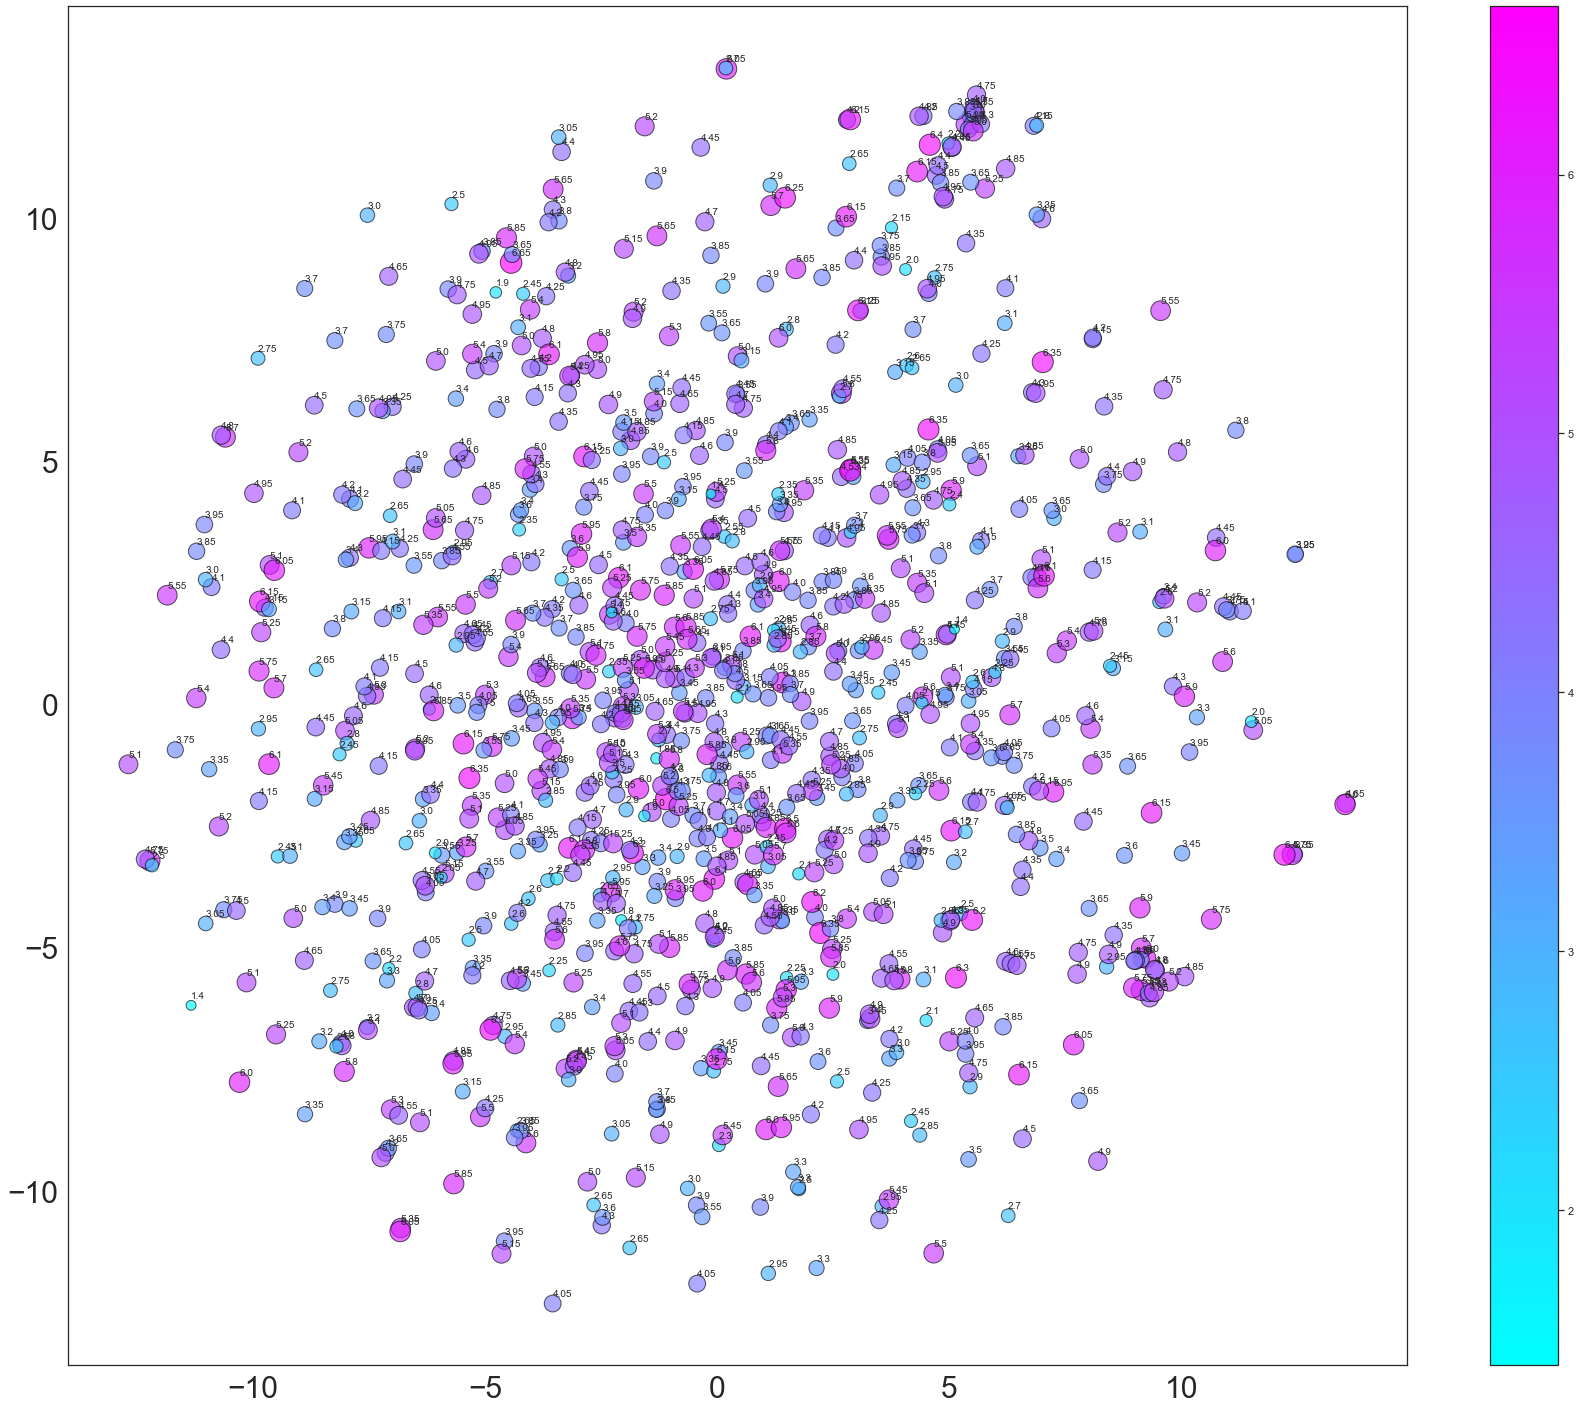

In [91]:
x_for_tsne, y_for_tsne = train_doc2vec(list_content, list_tag, "post_comment.model", "tsne")
t_sne(x_for_tsne, y_for_tsne, list_satisfaction, 'x', 'y')

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400


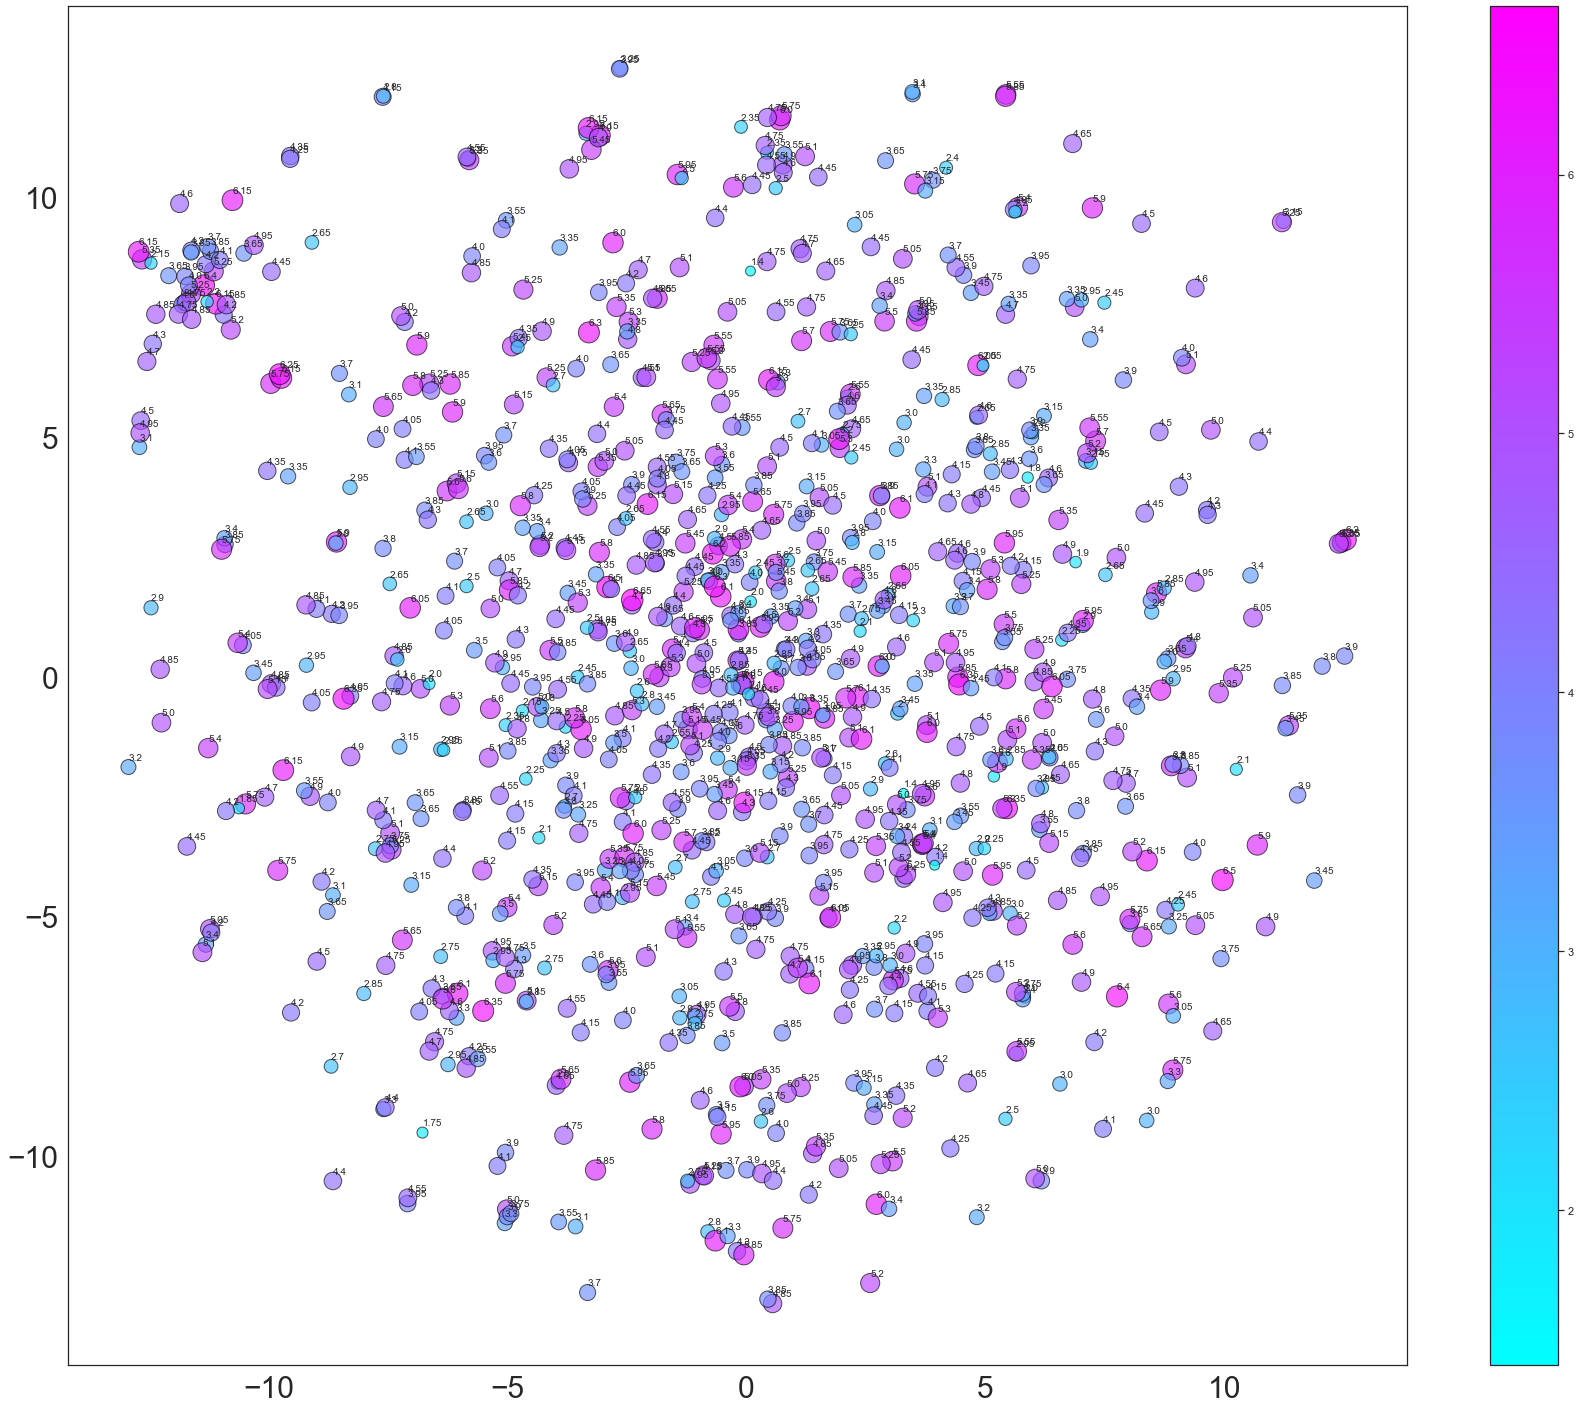

In [92]:
x_for_tsne, y_for_tsne = train_doc2vec(list_post, list_tag, "post.model", "tsne")
t_sne(x_for_tsne, y_for_tsne, list_satisfaction, 'x', 'y')

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400


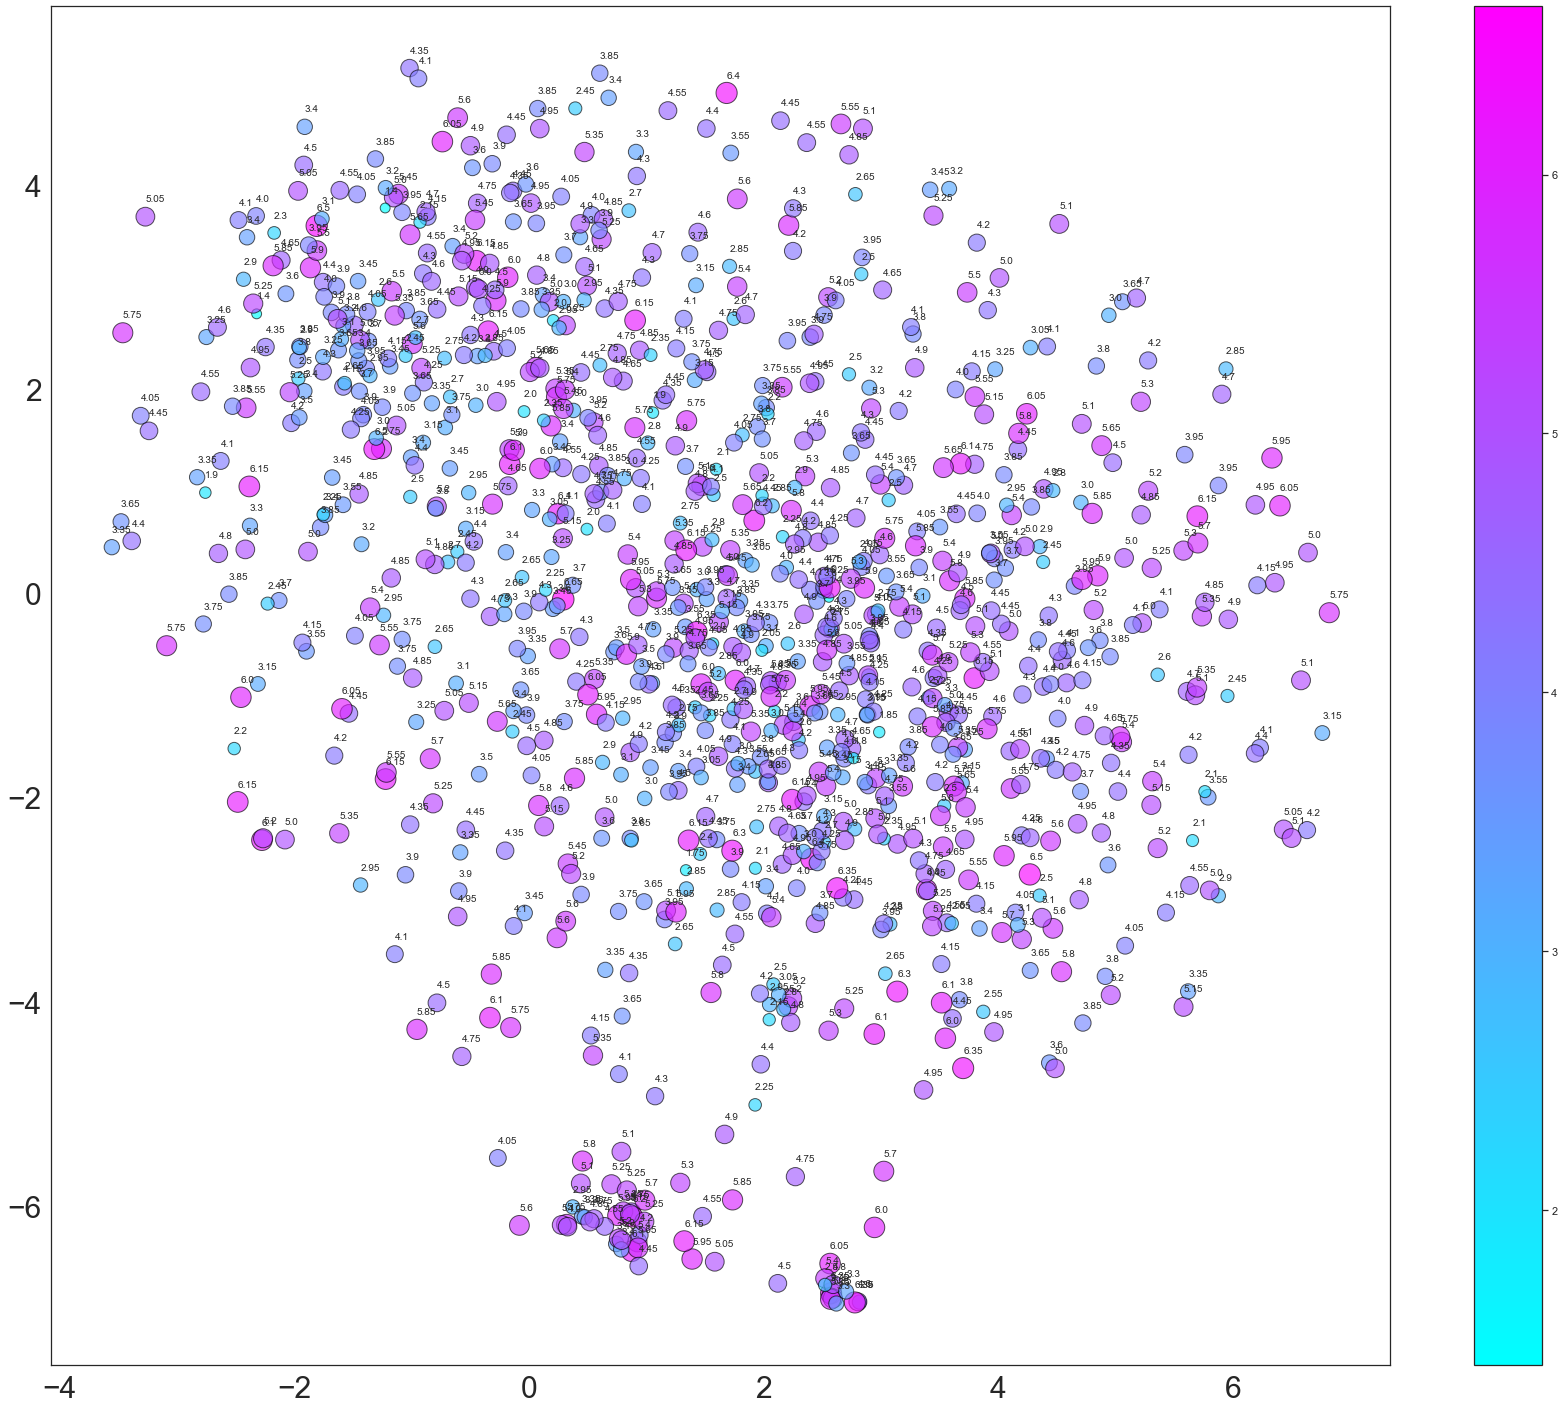

In [93]:
x_for_tsne, y_for_tsne = train_doc2vec(list_comment, list_tag, "comment.model", "tsne")
t_sne(x_for_tsne, y_for_tsne, list_satisfaction, 'x', 'y')

In [7]:
embeddings = train_doc2vec(list_content, list_tag, "post_comment.model", "regression")

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400


In [10]:
print(len(embeddings))

1000


In [11]:
data = []
for i in range(len(embeddings)):
    data.append([embeddings[i], list_satisfaction[i]])
data = pd.DataFrame(data, columns=['x', 'y'])

In [14]:
# train-test split
test_size = 0.2
train, test = train_test_split(data, test_size=0.2)

x_train = torch.Tensor([x for x in list(train.x)])
y_train = torch.Tensor([[y] for y in list(train.y)])

x_test = torch.Tensor([x for x in list(test.x)])
y_test = torch.Tensor([[y] for y in list(test.y)])


train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

batch_size = 5
train_dl = DataLoader(train_data, batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size, shuffle=True)

In [19]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        logit = self.fc2(self.fc1(x))
        output = self.fc1(x)
        output = self.dropout(output)
        output = self.relu(output)
        logit = self.fc2(output)

        return logit


def regression(num_epochs, model, loss_fun, optimizer, train_dl, test_dl):
    training_result = []

    for epoch in range(1, num_epochs+1):
        avg_loss = 0
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fun(pred, yb)
            avg_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, avg_loss / len(train_dl)))

        pred_df, true_df, val_loss, r2score = evaluate(test_dl)

        training_result.append([epoch, avg_loss / len(train_dl), val_loss, r2score])

        pred_df.to_csv(f'../predicting-satisfaction-using-graphs/csv/doc2vec/epoch_{epoch}_predicted_vals.csv')

        # validation_loss, r2 = evaluate(test_dl)
    true_df.to_csv(f'../predicting-satisfaction-using-graphs/csv/doc2vec/true_vals.csv')

    fields = ['epoch', 'training_loss', 'validation_loss', 'r^2_score']

    with open(
            f'../predicting-satisfaction-using-graphs/csv/doc2vec/training_result.csv',
            'w', newline='') as f:
        # using csv.writer method from CSV package
        write = csv.writer(f)

        write.writerow(fields)
        write.writerows(training_result)


def evaluate(test_dl):
    avg_loss = 0
    predictions = []
    true_vals = []
    for xb, yb in test_dl:
        pred = model(xb)
        loss = loss_fun(pred, yb)
        avg_loss += loss.item()

        pred = pred.detach().cpu().numpy()
        yb = yb.detach().cpu().numpy()

        predictions.append(pred)
        true_vals.append(yb)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    pred_df = pd.DataFrame(torch.Tensor(predictions).tolist())
    true_df = pd.DataFrame(torch.Tensor(true_vals).tolist())

    # print('validation loss: {:.4f}, R^2 score: {:.4f}'.format((avg_loss / len(test_dl)), r2_score(true_vals, predictions)))
    return pred_df, true_df, avg_loss / len(test_dl), r2_score(true_vals, predictions)

In [20]:
model = Regressor()
loss_fun = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

num_epochs = 7000
regression(num_epochs, model, loss_fun, optimizer, train_dl, test_dl)

Epoch [10/7000], Loss: 2.5594
Epoch [20/7000], Loss: 2.1528
Epoch [30/7000], Loss: 1.9292
Epoch [40/7000], Loss: 1.7086
Epoch [50/7000], Loss: 1.6926
Epoch [60/7000], Loss: 1.5705
Epoch [70/7000], Loss: 1.4929
Epoch [80/7000], Loss: 1.4736
Epoch [90/7000], Loss: 1.3915
Epoch [100/7000], Loss: 1.3836
Epoch [110/7000], Loss: 1.3187
Epoch [120/7000], Loss: 1.3236
Epoch [130/7000], Loss: 1.3248
Epoch [140/7000], Loss: 1.3081
Epoch [150/7000], Loss: 1.2890
Epoch [160/7000], Loss: 1.2701
Epoch [170/7000], Loss: 1.2510
Epoch [180/7000], Loss: 1.2378
Epoch [190/7000], Loss: 1.2161
Epoch [200/7000], Loss: 1.2435
Epoch [210/7000], Loss: 1.1657
Epoch [220/7000], Loss: 1.2129
Epoch [230/7000], Loss: 1.1752
Epoch [240/7000], Loss: 1.1581
Epoch [250/7000], Loss: 1.1374
Epoch [260/7000], Loss: 1.0981
Epoch [270/7000], Loss: 1.1345
Epoch [280/7000], Loss: 1.0950
Epoch [290/7000], Loss: 1.0472
Epoch [300/7000], Loss: 1.0926
Epoch [310/7000], Loss: 1.0933
Epoch [320/7000], Loss: 1.0685
Epoch [330/7000],

Epoch [2610/7000], Loss: 0.3666
Epoch [2620/7000], Loss: 0.3514
Epoch [2630/7000], Loss: 0.3611
Epoch [2640/7000], Loss: 0.3514
Epoch [2650/7000], Loss: 0.4067
Epoch [2660/7000], Loss: 0.3704
Epoch [2670/7000], Loss: 0.3312
Epoch [2680/7000], Loss: 0.3478
Epoch [2690/7000], Loss: 0.3750
Epoch [2700/7000], Loss: 0.3455
Epoch [2710/7000], Loss: 0.3699
Epoch [2720/7000], Loss: 0.3749
Epoch [2730/7000], Loss: 0.3878
Epoch [2740/7000], Loss: 0.3422
Epoch [2750/7000], Loss: 0.3614
Epoch [2760/7000], Loss: 0.3446
Epoch [2770/7000], Loss: 0.3607
Epoch [2780/7000], Loss: 0.3781
Epoch [2790/7000], Loss: 0.3398
Epoch [2800/7000], Loss: 0.3317
Epoch [2810/7000], Loss: 0.3676
Epoch [2820/7000], Loss: 0.3349
Epoch [2830/7000], Loss: 0.3285
Epoch [2840/7000], Loss: 0.3532
Epoch [2850/7000], Loss: 0.3375
Epoch [2860/7000], Loss: 0.3578
Epoch [2870/7000], Loss: 0.3244
Epoch [2880/7000], Loss: 0.3519
Epoch [2890/7000], Loss: 0.3290
Epoch [2900/7000], Loss: 0.3219
Epoch [2910/7000], Loss: 0.3439
Epoch [2

Epoch [5180/7000], Loss: 0.2388
Epoch [5190/7000], Loss: 0.2369
Epoch [5200/7000], Loss: 0.2617
Epoch [5210/7000], Loss: 0.2053
Epoch [5220/7000], Loss: 0.2043
Epoch [5230/7000], Loss: 0.2470
Epoch [5240/7000], Loss: 0.2662
Epoch [5250/7000], Loss: 0.2304
Epoch [5260/7000], Loss: 0.2408
Epoch [5270/7000], Loss: 0.2301
Epoch [5280/7000], Loss: 0.2393
Epoch [5290/7000], Loss: 0.2411
Epoch [5300/7000], Loss: 0.2380
Epoch [5310/7000], Loss: 0.2361
Epoch [5320/7000], Loss: 0.2253
Epoch [5330/7000], Loss: 0.2536
Epoch [5340/7000], Loss: 0.2240
Epoch [5350/7000], Loss: 0.2115
Epoch [5360/7000], Loss: 0.2107
Epoch [5370/7000], Loss: 0.2342
Epoch [5380/7000], Loss: 0.2265
Epoch [5390/7000], Loss: 0.2503
Epoch [5400/7000], Loss: 0.2127
Epoch [5410/7000], Loss: 0.2329
Epoch [5420/7000], Loss: 0.2535
Epoch [5430/7000], Loss: 0.2207
Epoch [5440/7000], Loss: 0.2150
Epoch [5450/7000], Loss: 0.2125
Epoch [5460/7000], Loss: 0.2231
Epoch [5470/7000], Loss: 0.2602
Epoch [5480/7000], Loss: 0.2273
Epoch [5